# DiffractionOnly_v1 Overlay Test

Este notebook carga el overlay `DiffractionOnly_v1` y compara la salida del kernel con una implementación en software.
Asegúrate de colocar `DiffractionOnly_v1.bit` y `DiffractionOnly_v1.hwh` en esta carpeta antes de ejecutar.

In [14]:
from pynq import Overlay, allocate
import numpy as np
import matplotlib.pyplot as plt
import time, sys
sys.path.append('../Deep_Tissue_Imaging_Acceleration/dti_reference_implementation')
from deep_tissue_imaging.elementos.lasers import fuente_microscopia_1 as laser, campo_tem00
from deep_tissue_imaging.elementos.tejidos import cerebro_emb_pez_cebra as tejido
from deep_tissue_imaging.propagators.step_operators import adi_x, adi_y

def plot_magnitude(field, title):
    plt.figure()
    plt.imshow(np.abs(field), cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [15]:
# Cargar overlay
ol = Overlay('diffraction_ovr.bit')
help(ol)


Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay diffraction_ovr.bit. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    axi_intc_0           : pynq.overlay.DefaultIP
    diffraction_only_0   : pynq.overlay.DefaultIP
    zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



In [16]:
# Instancia del IP - cambia el nombre si es diferente
ip = ol.diffraction_only_0
print(ip.register_map)

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  phi_in_1 = Register(phi_in=write-only),
  phi_in_2 = Register(phi_in=write-only),
  phi_out_1 = Register(phi_out=write-only),
  phi_out_2 = Register(phi_out=write-only)
}


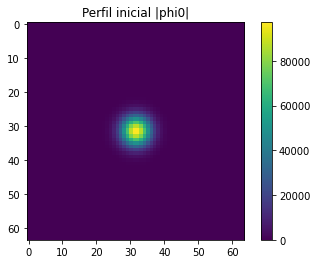

In [17]:
# Configurar dominio y campo inicial
Lz = np.float32(361e-6)
Nz = 361
dz = np.float32(Lz / Nz)
Lx = Ly = np.float32(45e-6)
Nx = Ny = 64
dx = np.float32(Lx / Nx)
dy = np.float32(Ly / Ny)
x = np.linspace(-Lx/2, Lx/2, Nx, dtype=np.float32)
y = np.linspace(-Ly/2, Ly/2, Ny, dtype=np.float32)
X, Y = np.meshgrid(x, y)
phi0 = campo_tem00(X, Y, laser.w0, laser.I_peak)

k0 = np.float32(2*np.pi / laser.wavelength)
k = np.float32(k0 * tejido.n_0)
eps = np.float32(1e-12)

plot_magnitude(phi0, 'Perfil inicial |phi0|')


In [18]:
# Implementación en software usando ADI
def diffraction_sw(phi):
    tmp = adi_x(phi, Ny, eps, k, dz, dx)
    return adi_y(tmp, Nx, eps, k, dz, dy)


Software time: 197.68 ms


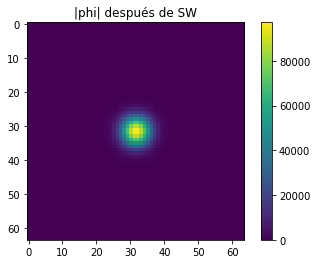

In [19]:
# Ejecutar en software
t0 = time.time()
sw_out = diffraction_sw(phi0)
sw_time = time.time() - t0
print(f'Software time: {sw_time*1e3:.2f} ms')
plot_magnitude(sw_out, '|phi| después de SW')


Hardware time: 5.16 ms


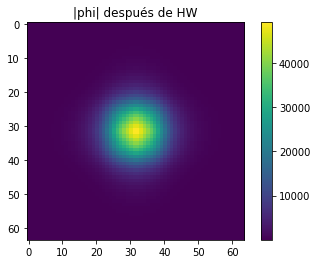

In [20]:
# Ejecutar en hardware
N = Nx * Ny
in_buffer = allocate(shape=(N,), dtype=np.complex64)
out_buffer = allocate(shape=(N,), dtype=np.complex64)
np.copyto(in_buffer, phi0.reshape(-1))

t0 = time.time()
ip.write(0x10, in_buffer.physical_address)
ip.write(0x1c, out_buffer.physical_address)
ip.write(0x00, 1)  # ap_start
while (ip.read(0x00) & 0x2) == 0:
    pass
hw_time = time.time() - t0
hw_out = np.array(out_buffer).reshape(Nx, Ny)
print(f'Hardware time: {hw_time*1e3:.2f} ms')
plot_magnitude(hw_out, '|phi| después de HW')


In [21]:
# Validación
diff = np.abs(sw_out - hw_out)
print('Max error:', diff.max())
print('HW faster by {:.2f}x'.format(sw_time / hw_time))


Max error: 109351.66
HW faster by 38.33x
